<a href="https://colab.research.google.com/github/rajanpbg/Demo_labs/blob/deeplearning/pytorch/10_BASIC_CNN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  Lets try basic CNN on pytorch

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
transform = transforms.Compose([transforms.Resize((28,28)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, ), (0.5, ))
                               ])
training_dataset =  datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset =  datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
 
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


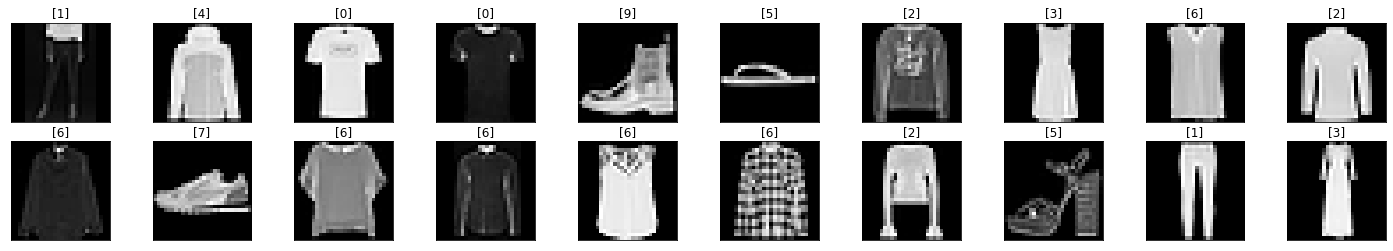

In [4]:
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5,0.5 )) + np.array((0.5,0.5,0.5 ))
  image = image.clip(0, 1)
  return image

dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))
 
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title([labels[idx].item()])

In [5]:
print(images[0].shape)

torch.Size([1, 28, 28])


In [21]:
class convClassifier(nn.Module):
    
    def __init__(self, D_in,  D_out):
        super(convClassifier,self).__init__()
        #
        self.conv1 = nn.Conv2d(1,32,3,1)  ## from 28 x 28 x 1 to 26 x 26 x 32  ## in pooling layer 13 x 13 x 32
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32,64,3,1)  ## from 13 x 13 x 32 to  11 x 11  x  64   ## in pooling layer  5 x 5 x  64 
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64,128,3,1)  ## from 5 x 5 x 64  to  3 x 3  x  128   ## in pooling layer  1 x 1 x  128 
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(1*1*128, 300)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(300,10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x,2,2)
        x = x.view(-1,1*1*128)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.softmax(x,dim=1)

In [22]:
model = convClassifier(1, 10).to(device)
model

convClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=128, out_features=300, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=300, out_features=10, bias=True)
)

In [23]:
from torchsummary import summary
summary(model, input_size=(1,28, 28),device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
       BatchNorm2d-2           [-1, 32, 26, 26]              64
            Conv2d-3           [-1, 64, 11, 11]          18,496
       BatchNorm2d-4           [-1, 64, 11, 11]             128
            Conv2d-5            [-1, 128, 3, 3]          73,856
       BatchNorm2d-6            [-1, 128, 3, 3]             256
            Linear-7                  [-1, 300]          38,700
           Dropout-8                  [-1, 300]               0
            Linear-9                   [-1, 10]           3,010
Total params: 134,830
Trainable params: 134,830
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.47
Params size (MB): 0.51
Estimated Total Size (MB): 0.99
-------------------------------------------

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [25]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

In [26]:
for i in range(epochs):
    running_loss = 0.0
    running_corrects = 0.0
    for inputs,labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        #print(inputs.shape)
        outputs = model(inputs)
        loss = criterion(outputs,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _,pred = torch.max(outputs,1)
        running_corrects += torch.sum(pred == labels.data)
    else:
        with torch.no_grad():
          validtion_loss = 0.0
          running_correct_vaid = 0.0
          for val_inputs,val_labels in  validation_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs,val_labels)
            _,pred = torch.max(val_outputs,1)
            running_correct_vaid  +=  torch.sum(pred == val_labels.data)
            validtion_loss +=  val_loss.item()   

        epoch_loss = running_loss / len(training_loader)
        running_corrects_data = running_corrects.float() / len(training_loader)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(running_corrects_data)
        print("training loss {:.4f}".format(epoch_loss))
        print("Correctvalue prediction {:.4f}".format(running_corrects_data))
        validation_loss_avg = validtion_loss  / len(validation_loader)
        running_correct_avg_val = running_correct_vaid  / len(validation_loader)
        val_running_loss_history.append(validation_loss_avg)
        val_running_corrects_history.append(running_correct_avg_val)
        print("Validation loss {:.4f}".format(validation_loss_avg))
        print("validation Correctvalue prediction {:.4f}".format(running_correct_avg_val))

training loss 1.7792
Correctvalue prediction 73.7283
Validation loss 1.6729
validation Correctvalue prediction 80.2200
training loss 1.6526
Correctvalue prediction 81.7500
Validation loss 1.6470
validation Correctvalue prediction 82.1200
training loss 1.6328
Correctvalue prediction 83.5483
Validation loss 1.6265
validation Correctvalue prediction 84.2700
training loss 1.6037
Correctvalue prediction 86.4783
Validation loss 1.6079
validation Correctvalue prediction 86.0400
training loss 1.5869
Correctvalue prediction 88.0800
Validation loss 1.6017
validation Correctvalue prediction 86.5900
training loss 1.5780
Correctvalue prediction 88.9150
Validation loss 1.5962
validation Correctvalue prediction 86.8400
training loss 1.5699
Correctvalue prediction 89.7150
Validation loss 1.5924
validation Correctvalue prediction 87.1200
training loss 1.5641
Correctvalue prediction 90.2883
Validation loss 1.5896
validation Correctvalue prediction 87.4700
training loss 1.5585
Correctvalue prediction 90.

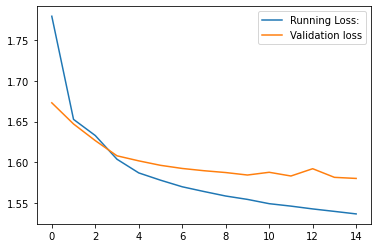

In [27]:

plt.plot(running_loss_history, label="Running Loss:")
plt.plot(val_running_loss_history,label="Validation loss")
plt.legend()
plt.show()

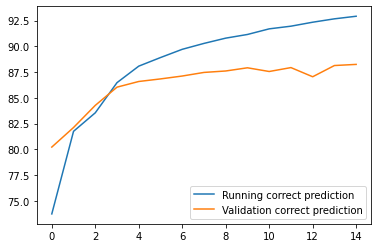

In [28]:

plt.plot(running_corrects_history, label="Running correct prediction")
plt.plot(val_running_corrects_history,label="Validation correct prediction")
plt.legend()
plt.show()


In [29]:
actuval = []
predicted = []
test_correct = 0 
test_loss = 0 
with torch.no_grad():
  for val_inputs,val_labels in  validation_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)
            val_outputs = model(val_inputs)
            test_loss = criterion(val_outputs,val_labels)
            _,pred = torch.max(val_outputs,1)
            test_correct  +=  torch.sum(pred == val_labels.data)
            #print(pred,labels.data)
            actuval.extend(val_labels.data.tolist())
            predicted.extend(pred.tolist())
            validtion_loss +=  val_loss.item()  
            #print(validtion_loss)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(actuval, predicted)
print(cm)

[[813   1  34  31   4   5 104   0   8   0]
 [  1 963   7  21   2   1   4   0   1   0]
 [  7   1 810  10  76   0  95   0   1   0]
 [ 10   2  22 897  28   0  37   0   3   1]
 [  1   0  35  25 859   1  76   0   3   0]
 [  1   0   0   4   0 961   0  20   2  12]
 [116   3  71  31 113   1 653   0  12   0]
 [  0   0   0   0   0  14   0 952   0  34]
 [  2   0   4   4   6   5   4   2 973   0]
 [  0   0   0   0   0   9   0  33   1 957]]


Confusion matrix, without normalization
[[813   1  34  31   4   5 104   0   8   0]
 [  1 963   7  21   2   1   4   0   1   0]
 [  7   1 810  10  76   0  95   0   1   0]
 [ 10   2  22 897  28   0  37   0   3   1]
 [  1   0  35  25 859   1  76   0   3   0]
 [  1   0   0   4   0 961   0  20   2  12]
 [116   3  71  31 113   1 653   0  12   0]
 [  0   0   0   0   0  14   0 952   0  34]
 [  2   0   4   4   6   5   4   2 973   0]
 [  0   0   0   0   0   9   0  33   1 957]]


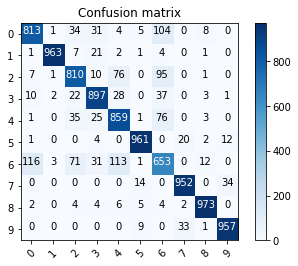

In [30]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")



plot_confusion_matrix(cm, list(range(10)))